# Detailed balance

For all $x$, $y$, $\pi(x | y) P(y) = \pi(y | x) P(x)$

# Metropolis-Hastings

1. Propose $x' ~ \pi(x' | x)$
2. Set $x$ to $x'$ with probability $\min\left(1, \frac{P(x')\pi(x | x')}{P(x)\pi(x' | x)} \right)$

# Ergodicity

# Slice sampling

Neal RM. Slice Sampling. The Annals of Statistics. 2003;31: 705–767.

Sample uniformly from the area under the density curve, only keep the horizontal coordinate.

1. Sample $y$ from $\mathbb{U}(0, P(x))$
2. Sample $x'$ from union of intervals such that $P(x') > y$

If step (2) is difficult, fine to use any proposal that keeps the uniform distribution over that interval union invariant. The target being uniform opens additional options.

## Stepping out + shrinkage proposal

1. Sample interval w/ width $w$ around $x$
2. Step out left/right until both endpoints outside the interval
    - Can also double the interval, choose which side randomly
3. Sample from the interval until it's inside the slice, shrink upon rejection

Important the the candidate states are chosen with the same probability whether you start at $x$ or $x'$.

Neal discusses interesting proof strategy:

Let's prove a stronger condition: $P(x', r | x) = P(x, f(r) | x')$ where $r$ are the random choices made while generating proposal, and $f$ is a 1:1 mapping w/ Jacobian = 1.

Can adapt $w$ if no limit is placed on the width of the interval expansion and distribution is known to be unimodal.

Direct N-D expansion possible, either by not expanding at all or using the doubling procedure and testing a random corner. Neal says it works less well than going dimension-by-dimension.

## Other proposals

- Neal has a cool pseudo-posterior method of generating candidate distributions based on past rejections.
- Overrelaxation -> if conditional dist is gaussian, choose samples on the other side of the mode as the current sample
- Can use HMC w/ reflections

# NUTS

## NUTS and slice sampling

In many ways, the original NUTS is literally slice sampling with a particular doubling scheme. It's quite similar in how it picks the doubling direction randomly.

The tree construction proceeds as follows:

1. Start at state $\theta_i, m_i$
2. Randomly go left or right from the current tree $2^j$ steps, where $j$ is the depth of the tree
3. Stop if either diverged, or one of the new states fails the U-turn criterion (grad of ESJD)
4. Sample from the set of feasible states using a distribution that preserves uniform distribution over the feasible states

It's important to discard states generated by (3) that would not be able to generate the entire tree (for reversibility). This is done by discarding entire output of (3) if any except the left/rightmost node satisfy the stopping conditions. Note that this means that we need to check every subtree... this is only $\log_2 j$ checks however, but this underlies the memory requirements.

Optimizations:

1. We can use a different kernel to sample from the feasible state, e.g. some sort of stick breaknig construction? The key point is that we no longer need to store all the feasible set states.
2. Can break out early when constructing the final tree doubling as soon as the bad thing is detected.

Acceptance probability:

Use the average acceptance probability on the final doubling iteration (weird?).

## Non-slice interpretation

Betancourt suggests just using multinomial sampling. The idea is that we propose a set of states such that this forms a reversible proposal, and then sample from them. Sampling a state from this proposed set merely has to preserve the 'canonical' density.

# Annealed Importance Sampling

Background: simulated annealing can be done within MCMC context, but no guarantee that the final samples are from the true distribution.

Given a sequence of unnormalized densities $\pi_j, j \in [0, n]$ where $\pi_0$ is the target distribution and a sequence of transition kernels $T_j(x' | x)$ which leaves $\tilde{\pi}_j$ invariant. $T_j$ need not be ergodic.

Now, generate a sequence of transitions, $x_n \sim \pi_n$, $x_{j - 1}\sim T_j(x_{j - 1} | x_j)$ and then the following weights:

$w_j = \frac{\pi_{j - 1}(x_{j - 1})}{\pi_j(x_{j - 1})}$, and the overall weight being $w^{(i)} = \prod_{j=1}^n w_j$

ESS can be computed via normalized weights as:

$ESS = \frac{1}{\sum_i w_i^2}$

This can be derived directly from a weighted sum representation:

$ESS = \frac{\sigma^2}{var[\hat{\theta}]} = \frac{\sigma^2}{\sum w^2 \sigma^2} = \frac{1}{\sum w^2}$

# Sequential Monte Carlo

There's at least two variants of SMC, unclear how they are related.

1. Dynamic: Have a sequence of unnormalized distributions $\pi_t(x_{1:t})$, $t \in [1, T]$
2. Static: Have a sequence of unnormalized distributions $\pi_t(x)$, $t \in [1, T]$ (note how this is reversed from AIS above).

## Dynamic

Construct a proposal distribution $q_t(x_{1:t}) = q_{t - 1}(x_{1:t-1})q_t(x_t | x_{1:t-1})$. We can now generate particles and weigh them as $w_t(x_{1:t}) =  w_{t - 1}(x_{1:t - 1}) \tilde{w}_t(x_{1:t})$ where $\tilde{w}_t(x_{1:t}) = \frac{\pi_t(x_{1:t})}{\pi_{t - 1}(x_{1:t - 1}) q_t(x_t | x_{1:t - 1})}$. The initial weight is a regular IS weight: $w_1 = \frac{\pi_1(x_1)}{q_1(x_1)}$.

Some examples:

Let's say $\pi_t(x_{1:t}) = \pi_1(x_1) \prod \pi_t(x_t | x_{t - 1})$, then $\tilde{w}_t(x_{1:t}) = \frac{\pi_t(x_t | x_{t - 1})}{q_t(x_t | x_{1:t - 1})}$

Let's say $\pi_t(x_{1:t}) = \pi_t(x_t) \prod \pi_{t-1}(x_{t-1} | x_t)$, then $\tilde{w}_t(x_{1:t}) = \frac{\pi_t(x_t) \pi_{t - 1}(x_{t - 1} | x_t)}{\pi_{t - 1}(x_{t - 1}) q_t(x_t | x_{1:t - 1})}$

Let's say $\pi_t(x_{1:t}) = \pi_1(x_1) \prod \pi_t(x_t | x_{t - 1}) \pi_t(y_t | x_t)$ and we choose $q_t(x_t | x_{1:t - 1}) = \pi_t(x_t | x_{t - 1})$, then $\tilde{w}_t(x_{1:t}) = \pi_t(y_t | x_t)$

Resampling: Goal is to discard unpromising particles, trade short term variance for long term. Convergence results show that one effect of this is reducing the effective dimensionality of the problem by resetting the system to only care about $q_t(x_t | x_{1:t-1})$. Because of this, only want to resample when ESS (or some other related criteria) is below a threshold. Don't want to do multinomial, but something more determinstic. Resampling should be done before any operation that does not affect importance weights to minimize the loss of information.

MCMC: Can insert MCMC steps (after resampling) that are invariant with respect to $\pi_t(x_{t - L:t})$ for some lag $L$.

## Static

We first contrast with (Static? Nomenclature is bad here) Sequential Importance Sampling, where we use a proposal distribution $q_t = \int dx\, q_{t - 1} T_t (x' | x)$, where $T$ is some transition kernel (if using MCMC, it'll target $\pi_t$). The issue is that for reasonable kernels $T$ we cannot compute the importance weights.

Instead, expand the state space to $x_{1:T}$ and construct a target distribution $\pi(x_{1:T}) = \pi_T \prod_{t=1}^{T - 1} L_t (x_t | x_{t + 1})$ where $L$ is the backward kernel. Note that now we have converted the problem into a dynamic one, so we can use the dynamic SMC methods to solve it. This isn't free, however, as we're not sampling over a larger space, incurring additional variance. This variance can be mitigated through a good choice of $L_t$, which is a free variable since we only care about the marginal for $t=T$.

Starting with a set of particles $w^{(i)}_{t - 1}(x^{(i)}_{1:t - 1})$, $x^{(i)}_{1:t - 1}$ that are targeting $\pi_{t-1}$, we can advance the particles by sampling from $T_t (x_t | x_{t - 1})$ and incrementing the weights as: $w^{(i)}_{t} = w^{(i)}_{t - 1}(x^{(i)}_{1:t - 1}) \tilde{w_t}(x_{t - 1}, x_{t})$ where $\tilde{w_t}(x_{t - 1}, x_{t}) = \frac{\pi_{t}(x_{t}) L_{t - 1}(x_{t - 1} | x_{t}) }{\pi_{t - 1}(x_{t - 1}) T_{t}(x_{t} | x_{t - 1})}$.

For AIS, we choose $L_{t - 1}(x_{t - 1} | x_{t}) = \frac{\pi_t(x_{t - 1}) T_t(x_{t - 1}, x_t)}{\pi_t(x_t)}$ which gives $\tilde{w_t}(x_{t - 1}, x_{t}) = \frac{\pi_{t}(x_{t - 1})}{\pi_{t - 1}(x_{t - 1})}$.

For example: let's say $\pi_{t}(x) = \pi(x) \prod \pi(y_t | x)$, then $\tilde{w_t} = \pi(y_t | x_{t - 1})$

Could resample the particles before applying the kernel, but need to be careful when to compute the weights (Read De Moral et al. 2006)

# Sticking the Landing

Roeder, G., Wu, Y., & Duvenaud, D. (2017). Sticking the Landing: Simple, Lower-Variance Gradient Estimators for Variational Inference. In arXiv [stat.ML]. arXiv. http://arxiv.org/abs/1703.09194

$ELBO \triangleq \mathbb{E}_{Q(z; \phi)} \left[ log P(x, z) - log Q(z; \phi) \right] \le P(x)$

We can compute gradients via reparameterization, given $z = f(\epsilon; \phi)$ where $\epsilon$ is distributed under some fixed distribution, meaning that the gradients of ELBO are:

$\nabla_\phi ELBO = \mathbb{E}_\epsilon \left[ \nabla_\phi \left[ log P(x, z) - log Q(z; \phi) \right] \right]$

Now, it turns out that while computing that derivative via autodiff, there are two pathways where the gradients flow from $\phi$: one via $z = f(\epsilon)$ and one via $\log |det \frac{\partial f}{\partial \phi}|$. We can see that by computing the total derivative wrt $\phi$, which has the two terms (indirect followed by direct):

$\frac{\partial}{\partial z} [\log P(x, z) - \log Q(z; \phi)] \frac{\partial}{\partial \phi} [f(\epsilon; \phi)] - \frac{\partial}{\partial \phi} \log Q(z; \phi)$

when the surrogate is perfect, the first term is zero everywhere, but the latter term is not, thus contributing some variance. It does have zero mean (we can show this by exchanging gradient and integral, the integral becoming 1), so we can try to remove it.

We do so by stopping the gradient used to compute the log-probability of Q. Note that in principle this term could be beneficial when surrogate is bad.

Note that this estimator is biased when the IWAE form is used, fixed in the doubly reparameterized gradient paper.

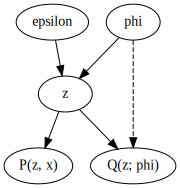

In [21]:
from graphviz import Digraph
dot = Digraph()

dot.node('epsilon')
dot.node('phi')
dot.node('z')
dot.node('P(z, x)')
dot.node('Q(z; phi)')

dot.edges([
    ['epsilon', 'z'],
    ['phi', 'z'],
    ['z', 'Q(z; phi)'],
    ['z', 'P(z, x)'],
])
dot.edge('phi', 'Q(z; phi)', style='dashed')

dot

# IWAE

Given $Q(z_{1:k}; \phi) = \prod_{k=1}^K Q(z_k; \phi)$, we can compute a closer bound to marginal likelihood as follows:

$ELBO_{IWAE} = \mathbb{E}_{Q(z_{1:k})} \left[ \log \frac{1}{K} \sum_k w_k \right]$.

where $w_k = \frac{P(x, z_k)}{Q(z_k; \phi)}$.

By default, increasing the K increases the relative amount of noise going into Q. This is not just because Q's contribution decreases, the gradients going into Q will go to 0, but they need not be noisy.

If $Q$ is reparameterizable, we can write $\nabla_\phi ELBO_{IWAE}$ as:

$\mathbb{E}_{\epsilon_{1:k}} \nabla_\phi \left[ \log \frac{1}{K} \sum_k w_k \right]$

$\mathbb{E}_{\epsilon_{1:k}} \left[ \frac{K}{\sum_k w_k} \nabla_\phi \frac{1}{K} \sum_k w_k \right]$

$\mathbb{E}_{\epsilon_{1:k}} \left[ \sum_k \frac{w_k}{\sum_k w_k} \nabla_\phi \log w_k \right]$

Like with Sticking the Landing, we can expand $\nabla_\phi \log w_k$ as:

$\frac{\partial}{\partial z_k} [\log P(x, z_k) - \log Q(z_k; \phi)] \frac{\partial}{\partial \phi} [f(\epsilon_k; \phi)] - \frac{\partial}{\partial \phi} \log Q(z_k; \phi)$

# VIMCO / REBAR

Write $ELBO_{IWAE}$ as 

$\mathbb{E}_{Q(z_{1:k})} \left[ \log \frac{1}{K} \sum_k w_k \right]$

where

$w_k = \frac{P(x, z_k)}{Q(z_k; \phi)}$

If we're using a REINFORCE estimator, we get:

$\mathbb{E}_{Q(z_{1:k})} \left[ \left( \log \frac{1}{K} \sum_k w_k \right) \nabla Q(z_{1:k}) + \nabla  \log \frac{1}{K} \sum_k w_k \right]$

The first term is high variance, so we need some control variate.

VIMCO uses a control variate based on leave-one-out geometric and arithmetic means.

REBAR uses a relaxation as a control variate.

# REINFORCE

Given $P(x; \theta)$ want to compute gradients of $\mathbb{E}_{P(x)} \left[ g(x; \theta) \right]$.

We can derive the following:

$\nabla \int dx P(x) g(x) = $

$\int dx g(x) \nabla P(x) + \int dx P(x) \nabla g(x)$

$\int dx g(x) P(x) \nabla \log P(x) + \mathbb{E} [\nabla g(x)]$

$\mathbb{E}_{P(x)} [g(x) \nabla \log P(x)] + \mathbb{E}_{P(x)} [ \nabla g(x)]$

compare with reparameterization $x = f(\epsilon)$:

$\mathbb{E}_{\epsilon} [\nabla g(f(\epsilon))]$

$\mathbb{E}_{\epsilon} [\frac{\partial}{\partial x} g(f(\epsilon)) \frac{\partial}{\partial \theta} f(\epsilon) + \frac{\partial}{\partial \theta} g(f(\epsilon))]$

$\mathbb{E}_{\epsilon} [\frac{\partial}{\partial x} g(f(\epsilon)) \frac{\partial}{\partial \theta} f(\epsilon)] + \mathbb{E}_{P(x)} [ \nabla g(x)]$

# Re-Weighted Wake Sleep

Given $P(x, z; \theta)$ and $Q(z | x; \phi)$, we can learn the parameters as follows:

**Wake $\theta$**

Optimize $ELBO$. Can use IWAE too.

**Sleep $\phi$**

Optimize $\mathbb{E}_{P(x; \theta)} \left[ -D_{KL} [ P(z | x; \theta) || Q(z | x; \phi) ] \right]$. The two expectations can be optimized by sampling from $P(x, z)$.

**Wake $\phi$**

$\mathbb{E}_{\hat{P}(x)} \left[ -D_{KL} [ P(z | x; \theta) || Q(z | x; \phi) ] \right]$. Note that the first expectation now uses the data distribution. The second expectation can be estimated via a self-normalized importance sampler using $Q(z | x; \phi)$ as the proposal. The self-normalization yields a biased estimator.

$\mathbb{E}_{z_{1:k}} \left[ \frac{w_k}{\sum_k w_k} \nabla_\phi \log Q(z | x; \phi) \right ]$

Which can be reparameterized (see DReG below)

# Doubly Reparameterized Gradient Estimator

Start with IWAE gradient estimator:

$\mathbb{E}_{\epsilon_{1:k}} \left[ \sum_k \frac{w_k}{\sum_k w_k} \left(\frac{\partial}{\partial z_k} \log w_k \frac{\partial}{\partial \phi} f(\epsilon_k; \phi) - \frac{\partial}{\partial \phi} \log Q(z_k; \phi) \right) \right]$

take the second term and write it as:

$\sum_k \mathbb{E}_{z_{/k}} \mathbb{E}_{z_{k}} \left[ \frac{w_k}{\sum_k w_k} \frac{\partial}{\partial \phi} \log Q(z_k; \phi)) \right ]$

We can do this because $z$ is treated as constant because this is a partial derivative. Now the inner expectation looks like a REINFORCE term, so we replace it with its reparameterized version (see the REINFORCE section):

$\mathbb{E}_{z_{k}} \left[ \frac{w_k}{\sum_k w_k} \frac{\partial}{\partial \phi} \log Q(z_k; \phi)) \right ]$

$\mathbb{E}_{\epsilon_{k}} \left[ \frac{\partial}{\partial z_k} \frac{w_k}{\sum_k w_k} \frac{\partial}{\partial \phi} f(\epsilon_k) \right ]$

By quotient rule:

$\mathbb{E}_{\epsilon_{k}} \left[ \left( \frac{1}{\sum_k w_k} - \frac{w_k}{(\sum_k w_k)^2} \right) \frac{\partial}{\partial z_k} w_k \frac{\partial}{\partial \phi} f(\epsilon_k) \right ]$

$\mathbb{E}_{\epsilon_{k}} \left[ \left( \frac{w_k}{\sum_k w_k} - \frac{w_k^2}{(\sum_k w_k)^2} \right) \frac{\partial}{\partial z_k} \log w_k \frac{\partial}{\partial \phi} f(\epsilon_k) \right ]$

When K = 1, this term vanishes (weirdly, it vanishes no matter the Q? maybe not that weird, given that we knew this term was 0 in IWAE already)

If we plug this into the original IWAE, we get:

$\mathbb{E}_{\epsilon_{1:k}} \left[ \sum_k \frac{w_k^2}{(\sum_k w_k)^2} \left(\frac{\partial}{\partial z_k} \log w_k \frac{\partial}{\partial \phi} f(\epsilon_k; \phi) \right) \right]$

So you... square the weights and stop the gradient to the $\log Q$ term I guess?